In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm

In [ ]:
extracted_dir_path = '/content/Identithem'
if not os.path.exists(extracted_dir_path):
    !git clone https://github.com/Identithem/Identithem.git
else:
    print("Directory already exists.")

%cd "/content/Identithem"
!git pull

Cloning into 'Identithem'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 82 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (82/82), 79.69 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/Identithem
Already up to date.


In [ ]:
extracted_dir_path = '/content/Identithem/preprocessed_logs'
if not os.path.exists(extracted_dir_path):
    # If the directory does not exist, unzip the zip file
    %cd "/content/Identithem"
    !unzip "preprocessed_logs.zip"
else:
    print("Directory already exists. Skipping unzip process.")

/content/Identithem
Archive:  preprocessed_logs.zip
  inflating: preprocessed_logs/logs_20240122.csv  
  inflating: preprocessed_logs/logs_20240123.csv  
  inflating: preprocessed_logs/logs_20240124.csv  
  inflating: preprocessed_logs/logs_20240125.csv  
  inflating: preprocessed_logs/logs_20240126.csv  
  inflating: preprocessed_logs/logs_20240127.csv  
  inflating: preprocessed_logs/logs_20240128.csv  
  inflating: preprocessed_logs/logs_20240129.csv  


In [ ]:
WINDOW_SIZE=10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def create_windows(dataset):
  num_features = len(dataset.columns) - 1 # index column will be removed
  num_samples = len(dataset)

  # Initialize list to store sequences
  sequences = []
  indices = []

  # Iterate through the dataset with a sliding window
  for i in range(num_samples - WINDOW_SIZE + 1):
      # Extract sequence of samples
      sequence = dataset[i:i+WINDOW_SIZE]
      index_values = sequence.pop('index').tolist()
      # Append sequence to list
      sequences.append(sequence)
      indices.append(index_values)

  # Convert sequences to numpy array
  sequences_array = np.array(sequences)

  # Reshape sequences array to [samples, timesteps, features]
  seq_train = sequences_array.reshape(-1, WINDOW_SIZE, num_features)

  return seq_train, indices


def pad_window(dataset):
  index_value = dataset.pop('index').tolist()

  num_features = len(dataset.columns)

  window = np.array(dataset)

  arrays_to_add = WINDOW_SIZE - len(window)

  # Create arrays filled with zeros to add
  additional_arrays = [np.zeros_like(window[0]) for _ in range(arrays_to_add)]

  # Concatenate the input arrays with additional arrays
  window = np.concatenate((window, additional_arrays), axis=0)

  return window, index_value + [None] * arrays_to_add

In [ ]:
def generate(df):
  df['index'] = df.index
  grouped_df = df.groupby('ip')
  ip_dataframes = {}
  inputs = []
  ips = []
  indices_list = []

  for ip, group in grouped_df:
      ip_dataframes[ip] = group.set_index('ip')

  for ip, ip_df in ip_dataframes.items():
    if len(ip_df)>1:
      if len(ip_df)>WINDOW_SIZE:
        windows, indices = create_windows(ip_df)
        for window, idx in zip(windows, indices):
          inputs.append(window)
          ips.append(ip)
          indices_list.append(idx)
      elif len(ip_df)==WINDOW_SIZE:
        idx = ip_df.pop('index').tolist()
        window = np.array(ip_df)
        inputs.append(window)
        ips.append(ip)
        indices_list.append(idx)
      else:
        window, indices = pad_window(ip_df)
        inputs.append(window)
        ips.append(ip)
        indices_list.append(indices)

  print('Number of sequences:', len(inputs))
  print('Number of IPs:', len(list(set(ips))))
  dataset = np.array(inputs)

  # dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float), torch.tensor(inputs, dtype=torch.float))
  return dataset, indices_list

In [ ]:
# train = pd.read_csv("/content/Identithem/identithem_logs_normal_onefile.csv")
# test = pd.read_csv("/content/Identithem/preprocessed_logs/logs_20240123.csv")
train = pd.read_csv("/content/identithem_logs_normal_onefile_day1.csv")
test = pd.read_csv("/content/test.csv")
print("Train DataFrame shape:", train.shape)
print("Test DataFrame shape:", test.shape)

Train DataFrame shape: (26774, 26)
Test DataFrame shape: (337356, 26)


In [ ]:
X_train, train_indices = generate(train)
X_test, test_indices = generate(test)

Number of sequences: 23636
Number of IPs: 450
Number of sequences: 300281
Number of IPs: 5691


In [ ]:
xtrain = X_train.copy()
xtest = X_test.copy()

In [ ]:
# normalize the data
scaler = MinMaxScaler()
train_reshaped = xtrain.reshape(-1, xtrain.shape[2])
X_train = scaler.fit_transform(train_reshaped)
X_train = X_train.reshape(xtrain.shape)
test_reshaped = xtest.reshape(-1, xtest.shape[2])
X_test = scaler.transform(test_reshaped)
X_test = X_test.reshape(xtest.shape)

In [ ]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (23636, 10, 25)
Test data shape: (300281, 10, 25)


In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # Encoder
    L1 = LSTM(2, activation='relu', return_sequences=False, # 50
              kernel_regularizer=regularizers.l2(0.0))(inputs)
    # Repeat the vector to match the input sequence length
    L2 = RepeatVector(X.shape[1])(L1)
    # Decoder
    L3 = LSTM(2, activation='relu', return_sequences=True)(L2)
    # Output layer
    output = TimeDistributed(Dense(X.shape[2]))(L3)
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 25)]          0         
                                                                 
 lstm (LSTM)                 (None, 2)                 224       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 2)             0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 10, 2)             40        
                                                                 
 time_distributed (TimeDist  (None, 10, 25)            75        
 ributed)                                                        
                                                                 
Total params: 339 (1.32 KB)
Trainable params: 339 (1.32 KB)
N

In [ ]:
nb_epochs = 10
batch_size = 64
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/10
351/351 [==============================] - 9s 16ms/step - loss: 0.1957 - val_loss: 0.1083
Epoch 2/10
351/351 [==============================] - 4s 11ms/step - loss: 0.0820 - val_loss: 0.0534
Epoch 3/10
351/351 [==============================] - 4s 10ms/step - loss: 0.0387 - val_loss: 0.0363
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.0240 - val_loss: 0.0316
Epoch 5/10
351/351 [==============================] - 5s 14ms/step - loss: 0.0199 - val_loss: 0.0302
Epoch 6/10
351/351 [==============================] - 4s 12ms/step - loss: 0.0189 - val_loss: 0.0299
Epoch 7/10
351/351 [==============================] - 4s 11ms/step - loss: 0.0185 - val_loss: 0.0329
Epoch 8/10
351/351 [==============================] - 6s 16ms/step - loss: 0.0181 - val_loss: 0.0371
Epoch 9/10
351/351 [==============================] - 4s 11ms/step - loss: 0.0179 - val_loss: 0.0392
Epoch 10/10
351/351 [==============================] - 4s 11ms/step - loss: 0.0178 - val_lo

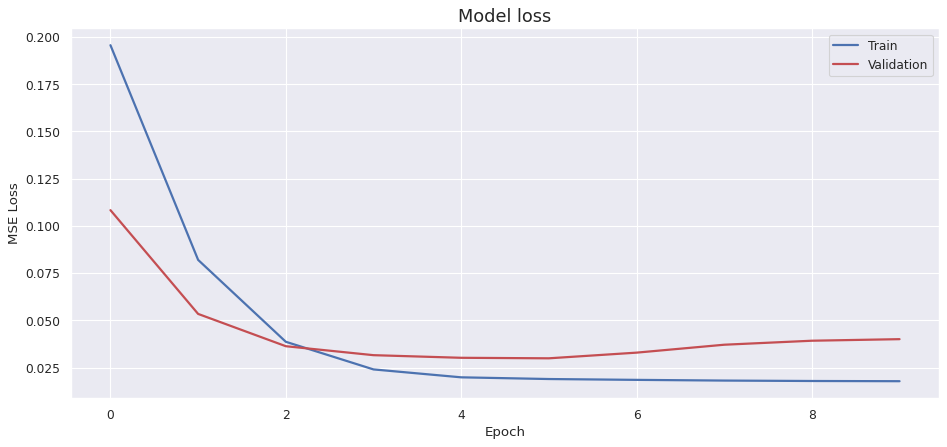

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('MSE Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
X_pred = model.predict(X_train)
# scored = pd.DataFrame()

739/739 [==============================] - 4s 5ms/step


In [ ]:
X_pred_test = model.predict(X_test)

9384/9384 [==============================] - 43s 5ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
train_losses = []

for i in range(len(X_pred)):
    pred_sample = X_pred[i]
    train_sample = X_train[i]

    # Reshape the samples if needed
    pred_sample_flat = pred_sample.reshape(-1)
    train_sample_flat = train_sample.reshape(-1)

    # Calculate Mean Squared Error (MSE)
    mse_loss = mean_squared_error(train_sample_flat, pred_sample_flat)
    train_losses.append(mse_loss)

In [ ]:
print(np.mean(train_losses))
print(np.min(train_losses),np.max(train_losses))

0.01887773145363639
0.0032425710618077448 0.18903239072015005


In [ ]:
test_losses = []

for i in range(len(X_pred_test)):
    pred_sample = X_pred_test[i]
    test_sample = X_test[i]

    # Reshape the samples if needed
    pred_sample_flat = pred_sample.reshape(-1)
    test_sample_flat = test_sample.reshape(-1)

    # Calculate Mean Squared Error (MSE)
    mse_loss = mean_squared_error(test_sample_flat, pred_sample_flat)
    test_losses.append(mse_loss)

In [ ]:
print(np.mean(test_losses))
print(np.min(test_losses),np.max(test_losses))

174.17006402068643
0.03935122244769474 12838.770641807754


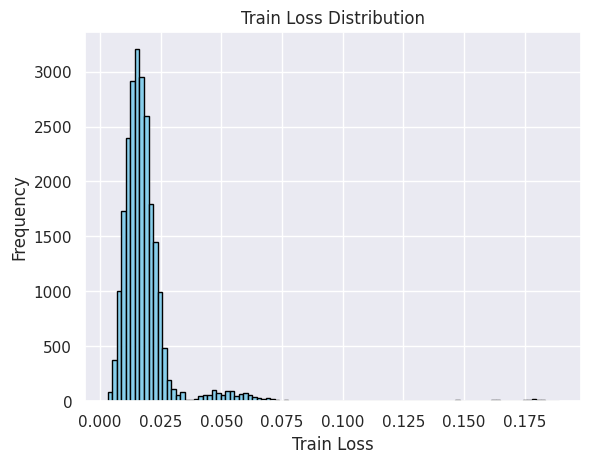

In [ ]:
# Plot histogram
plt.hist(train_losses, bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Train Loss')
plt.ylabel('Frequency')
plt.title('Train Loss Distribution')

# Show plot
plt.show()

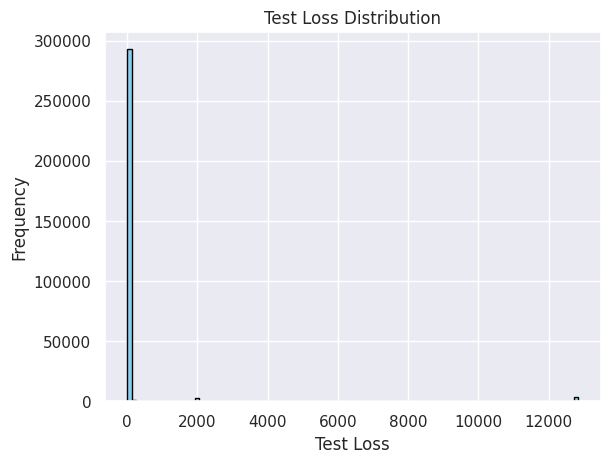

In [ ]:
# Plot histogram
plt.hist(test_losses, bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Test Loss')
plt.ylabel('Frequency')
plt.title('Test Loss Distribution')

# Show plot
plt.show()

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def threshold_based_scoring(losses, train_losses):
    max_train_losses = np.max(train_losses)

    threshold = np.median([x for x in test_losses if x>max_train_losses])

    losses = np.array(losses)

    scores = np.zeros_like(losses, dtype=float)

    # Only consider losses above the threshold
    above_threshold = losses > threshold
    adjusted_losses = losses[above_threshold] - threshold  # Shift losses to start from the threshold

    # Apply the sigmoid function to the adjusted losses
    sigmoid_scores = sigmoid(adjusted_losses)

    # Assign sigmoid scores to the corresponding positions
    scores[above_threshold] = sigmoid_scores

    return scores

In [ ]:
anomaly_scores = threshold_based_scoring(test_losses, train_losses)

In [ ]:
min(anomaly_scores), max(anomaly_scores)

(0.0, 1.0)

In [ ]:
scored = pd.DataFrame(index=range(len(test_losses)))
scored['Log lines'] = test_indices
ip = [test['ip'][scored['Log lines'][i][0]] for i in range(len(scored))]
scored['ip'] = ip
scored['Loss_mse'] = test_losses
scored['Anomaly score'] = anomaly_scores
# scored['Threshold'] = 0.3 # Change accordingly
# scored['Anomaly'] = scored['Anomaly score'] > scored['Threshold']
# scored[scored["Anomaly"]== True]

In [ ]:
scored.to_csv("sequence_anomaly_scores.csv", index=True)

In [ ]:
scored[scored["Anomaly"]== True]['ip'].nunique()

1071

In [ ]:
anomaly_ips = scored.groupby('ip')
seqs_per_ip = anomaly_ips.size()
anomaly_count = anomaly_ips['Anomaly'].sum()
anomalies_per_ip = pd.DataFrame({'Sequences Count': seqs_per_ip, 'Anomaly Count': anomaly_count})

In [ ]:
anomalies_per_ip[anomalies_per_ip['Anomaly Count']>0]

,Sequences Count,Anomaly Count
ip,,
381488,1,1
835162,120,10
3208896,1,1
3238705,1,1
3816687,7,4
...,...,...
130255166142,1,1
173239224181,1,1
174129131202,1,1
